# ImageCLEF Medical Caption Task 2019

The Image CLEF 2019 Concept Detection Task is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images. Implement a system to classify a medical image based on several abnormalities represented by Unified Medical Language System (UMLS) concept IDs.

The AUEB NLP Group won the competition with this paper. This assignment was prepared by Vasiliki Kougia and John Pavlopoulos.

In this assignment, use the ImageCLEF data and train a newral network model that will try to predict the image classes

---

> Ioannis Petropoulos <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> ionpetro@gmail.com

## Getting the Data

* The training data exist in Google Drive.

* You can download the training and validation data from <https://drive.google.com/uc?id=1UOccw0VNCiRTwaQSEJMhiYWXhizvKptX> and the test data from <https://drive.google.com/uc?id=1diO2apPPFJeTH8CGcd3S55OUNTXtJVu2>. Alternatively, you can use the [gdown](https://github.com/wkentaro/gdown) utility; the file IDs are `1UOccw0VNCiRTwaQSEJMhiYWXhizvKptX` and `1diO2apPPFJeTH8CGcd3S55OUNTXtJVu2`.

* The data are organised as follows:

  * `training-set`: 56,629 training images.
  
  * `validation-set`: 14,157 validation images.

  * `Last`; rename it to `test-set`: 10,000 images used for testing. The test images have no annotations. They will be used for assessment.
  
  * `train_concepts.csv`: the image IDs of the training set with their gold (i.e., known correct) tags, separated with `;`.
  
  * `val_concepts.csv`: the validation image IDs with their gold tags, separated with `;`.

  * `string_concepts.csv`: all the available tag IDs and their corresponding name, separated with tabs.

Let's first import the libraries needed for the analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#preferred style
plt.style.use('seaborn')

import numpy as np
import cv2
import os
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))

from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

Using TensorFlow backend.


Let's read the concepts

In [2]:
string_consepts = 'ImageCLEF2019/string_concepts.csv'
train_consepts = 'ImageCLEF2019/train_concepts.csv'
val_concepts = 'ImageCLEF2019/val_concepts.csv'

str_con = pd.read_csv(string_consepts, sep='\t', header=None)
train_con = pd.read_csv(train_consepts)
val_con = pd.read_csv(val_concepts)

## Exploring the data

They look something like that

In [3]:
train_con.head()

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743


In [4]:
str_con.head()

,0,1
0,C0032143,r-tpa
1,C0225516,lower hypopharyngeal region
2,C0825429,bone surface
3,C0020461,excessive potassium in the blood
4,C0947912,proximal muscle weakness due to defect at the ...


We save the image paths on seperate folders

In [5]:
training_set = 'ImageCLEF2019/training-set/'
test_set = 'ImageCLEF2019/test-set/'
validation_set = 'ImageCLEF2019/validation-set/'

* Let's discover some of the training images

* What we need is a method that brings the tags given an image

In [6]:
# add header to str_con
str_con.rename(columns={0: 'tag', 1: 'tag_name'}, inplace=True)

In [7]:
# method that grabs all the tag names for the tag string given
def fetch_tags(tag):
    tags = tag.split(';')
    ids = []
    names = []
    for tag in tags:
        ids.append(tag)
        index = str_con.loc[str_con.tag == tag]
        names.append(index.tag_name.values[0])
    return ids, names

Let's see some radiology images and the abnormality related to it 

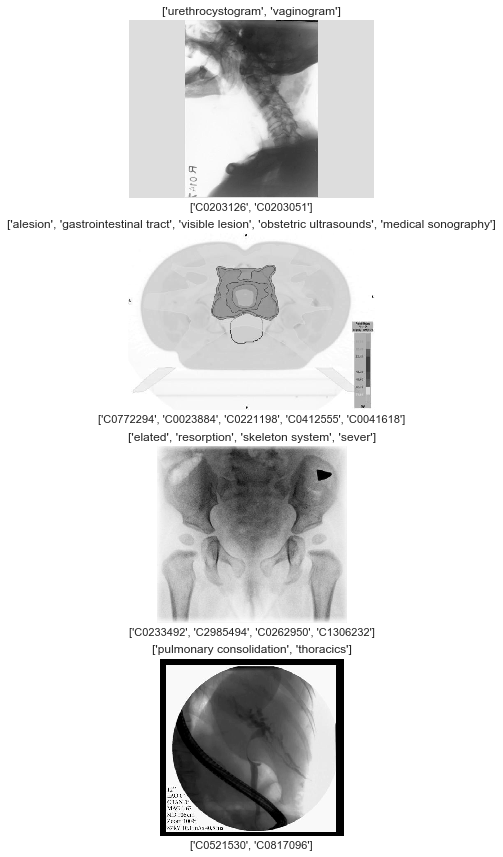

In [8]:
plt.figure(figsize=(15,15))
for index, i in enumerate(os.listdir(training_set)[:4]):
    img = cv2.imread(training_set + i,0)
    plt.subplot(4,1,index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    ids, names = fetch_tags(train_con.iloc[index, 1])
    _ = plt.title(names)
    _ = plt.xlabel(ids)

Let's find out the maximum and the minimum number of tags per image.

In [9]:
maximum = 0
tags = train_con.tags
for tag in tags:
    tag = tag.split(';')
    if len(tag) >= maximum:
        maximum = len(tag)
        
minimum = 1000
tags = train_con.tags
for tag in tags:
    tag = tag.split(';')
    if len(tag) <= minimum:
        minimum = len(tag)
        
print("The maximum number of tags is {0} and the minimum is {1}".format(maximum, minimum))

The maximum number of tags is 72 and the minimum is 1


* What is the most frequent one?

* We will create a method that counts the tags per image and puts them in a dictionary

In [10]:
# method that counts all the tag_ids and
# puts the in a dictionary
tag_dic = {}
for tag in tags:
    items = tag.split(';')
    for item in items:
        if item not in tag_dic.keys():
            tag_dic[item] = 1
        else:
            tag_dic[item] += 1

tag_df = pd.DataFrame.from_dict(tag_dic, orient='index', columns=['tag_count'])

This is how it looks now

In [11]:
tag_df.head()

,tag_count
C0203126,131
C0203051,2
C0772294,4512
C0023884,1162
C0221198,4513


Let's add to the dataframne the names of the tags

In [12]:
tag_df = pd.merge(tag_df, str_con, left_index=True, right_on='tag', how='inner')
tag_df.reset_index(inplace=True)
tag_df.drop(columns=['index'], inplace=True)
tag_df.sort_values(by=['tag_count'], ascending=False, inplace=True)

Now we got everything we need

In [104]:
tag_df.head(7)

,tag_count,tag,tag_name
57,6733,C0441633,diagnostic scanning
41,6321,C0043299,x-ray procedure
48,6318,C1962945,radiogr
27,6235,C0040395,tomogr
29,6127,C0034579,pantomogr
12,5981,C0817096,thoracics
36,5801,C0040405,x-ray computer assisted tomography


Now we are ready to plot

<Figure size 432x288 with 0 Axes>

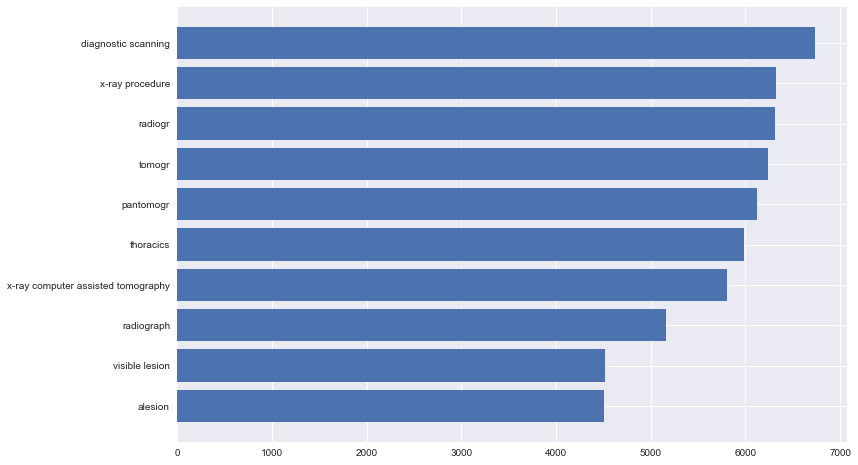

In [24]:
first_ten = tag_df[:10]
reverse = first_ten[::-1]
font_size = 20
fig = plt.figure()
plt.figure(figsize=[12, 8])
_ = plt.barh(reverse.tag_name[:10], width=reverse.tag_count[:10])

## Data Preprocessing

We have to create an image generator

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

batch_size = 128
epochs = 5
IMG_HEIGHT = 224
IMG_WIDTH = 225

We might want to
* change the images to filenames
* change the train_con tags to a list so the classes are separated

In [27]:
train_con_list = train_con.copy()
train_con_list['tags'] = train_con_list['tags'].apply(lambda x:x.split(';'))
train_con_list['image'] = train_con_list['image'].apply(lambda x:x + ('.jpg'))

In [28]:
valid_con_list = val_con.copy()
valid_con_list['tags'] = valid_con_list['tags'].apply(lambda x:x.split(';'))
valid_con_list['image'] = valid_con_list['image'].apply(lambda x:x + ('.jpg'))

So it looks something like that

In [29]:
valid_con_list.head()

,image,tags
0,ROCO_CLEF_64017.jpg,"[C0001074, C3203359, C0041618]"
1,ROCO_CLEF_39073.jpg,"[C0027530, C1610719, C0065967, C1704258, C0883..."
2,ROCO_CLEF_18028.jpg,"[C1265876, C1293134, C0029053, C0034579, C0025..."
3,ROCO_CLEF_02052.jpg,"[C0040426, C1962945, C0043299, C0036849, C0150..."
4,ROCO_CLEF_67927.jpg,"[C0184666, C4085643, C4049705, C4049706, C4321..."


In [30]:
train_con_list.head()

,image,tags
0,ROCO_CLEF_07350.jpg,"[C0203126, C0203051]"
1,ROCO_CLEF_19073.jpg,"[C0772294, C0023884, C0221198, C0412555, C0041..."
2,ROCO_CLEF_60501.jpg,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564.jpg,"[C0521530, C0817096]"
4,ROCO_CLEF_55020.jpg,"[C0935598, C1184743]"


We will also need the different classes

In [31]:
classes = list(str_con.tag)

## Dummy Classifier

What is the score for a classifier that only predicts the frequent values?

In [105]:
dummy = val_con.copy()

In [107]:
dummy.drop(columns=['tags'], inplace=True)

In [111]:
# the top 7 most frequent classes
dummy['predictions'] = 'C0034579;C0040395;C1962945;C0043299;C0441633;C0817096;C0040405'

In [112]:
dummy.head()

,image,predictions
0,ROCO_CLEF_64017,C0034579;C0040395;C1962945;C0043299;C0441633;C...
1,ROCO_CLEF_39073,C0034579;C0040395;C1962945;C0043299;C0441633;C...
2,ROCO_CLEF_18028,C0034579;C0040395;C1962945;C0043299;C0441633;C...
3,ROCO_CLEF_02052,C0034579;C0040395;C1962945;C0043299;C0441633;C...
4,ROCO_CLEF_67927,C0034579;C0040395;C1962945;C0043299;C0441633;C...


In [110]:
dummy.to_csv("candidate_dummy.tsv", sep="\t", index=False, header=False)

```
Least concepts in set : 1
Most concepts in set : 77
Average concepts in set : 6.140213322031504
Final result
********************************
Obtained score : 1533.6623568706698 / 14157
Mean score over all concept sets : 0.1083324402677594

```

The mean score over all concepts is **0.1** 

### CNN version 1

In [32]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=train_con_list,
                                                           directory=training_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

Found 56629 validated image filenames belonging to 5528 classes.


In [33]:
valid_data_gen = validation_image_generator.flow_from_dataframe(dataframe=valid_con_list,
                                                           directory=validation_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

Found 14157 validated image filenames belonging to 5528 classes.


For our first model, we will build a very basic one

In [34]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(5528, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

The model looks something like this

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 225, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)       

In [26]:
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size

# STEP_SIZE_TRAIN = 3
# STEP_SIZE_VALID = 3

history = model.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=STEP_SIZE_VALID
)

Epoch 1/5
442/442 [==============================] - 3086s 7s/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.0071 - val_accuracy: 0.9989
Epoch 2/5
442/442 [==============================] - 3210s 7s/step - loss: 0.0067 - accuracy: 0.9989 - val_loss: 0.0067 - val_accuracy: 0.9989
Epoch 3/5
442/442 [==============================] - 3139s 7s/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 4/5
442/442 [==============================] - 3215s 7s/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0071 - val_accuracy: 0.9989
Epoch 5/5
442/442 [==============================] - 3173s 7s/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0077 - val_accuracy: 0.9989


We need to save the model, so we don't have to train again and again

In [27]:
# save model
model.save('models/cnn_v1.h5')

So now, we can run the notebook and load the model we saved previously

In [36]:
## load model
from keras.models import load_model
model = load_model('models/cnn_v1.h5')

### Model Evaluation

In [37]:
# STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size

pred = model.predict(valid_data_gen, verbose=1)

111/111 [==============================] - 136s 1s/step


```pred``` is an array of predictions, containing the probability an image belongs to a specific classes. Thus, the shape of the pred array is:

In [38]:
pred.shape

(14157, 5528)

* We will set a threshold to 0.16. This means that if the model is more than 16% sure that an image belongs to a specific class, we will accept it.
* What we will get is a boolean dataframe

In [39]:
high_pred = (pred > 0.16)

We can find the tags order on ```class_indices```

In [40]:
pred_df = pd.DataFrame(high_pred, columns=valid_data_gen.class_indices)

In [41]:
pred_df.head()

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


* In order to proceed with the evaluation of the model, we have to collect all the tags that the model predicted with more than 0.16 confidence.
* To do so, we will create the following algorithm, that will iterate through the rows and columns of the dataframe, and collect the tags for each image 

In [42]:
results = {}
for rindex, row in pred_df.iterrows():
    cla = []
    for cindex, col in enumerate(pred_df):
        if pred_df.iloc[rindex, cindex] == True:
            cla.append(col)
    results[rindex] = cla
    print(rindex)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704


5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344


6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983


8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625


10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
1022

11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
1158

12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
1295

In [43]:
results

{0: [],
 1: [],
 2: ['C0817096'],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: ['C0043299', 'C1962945'],
 10: [],
 11: [],
 12: [],
 13: [],
 14: ['C0817096'],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: ['C0041618', 'C0412555'],
 26: [],
 27: [],
 28: [],
 29: ['C0040395'],
 30: [],
 31: [],
 32: [],
 33: ['C0441633'],
 34: [],
 35: ['C1963113'],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: ['C0796494'],
 43: ['C0441633'],
 44: [],
 45: ['C0024109', 'C0817096'],
 46: ['C0441633'],
 47: [],
 48: [],
 49: [],
 50: [],
 51: ['C0043299', 'C1962945'],
 52: ['C0040395'],
 53: [],
 54: [],
 55: [],
 56: [],
 57: ['C0441633'],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: ['C1704302'],
 66: [],
 67: [],
 68: ['C0034579', 'C0040395'],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: ['C0040395'],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [

In [44]:
save_results = results
for key in results:
    save_results[key] = ";".join(save_results[key]) 

In [45]:
# save the results on a dataframe
df_val_results = pd.DataFrame.from_dict(save_results, orient='index')

In [46]:
df_val_results.head()

,0
0,
1,
2,C0817096
3,
4,


We can find the images on the **validation_concepts** dataframe

In [47]:
merge_df_val_res = pd.merge(val_con.iloc[:, 0], df_val_results, left_index=True, right_index=True)

In [48]:
merge_df_val_res.head()

,image,0
0,ROCO_CLEF_64017,
1,ROCO_CLEF_39073,
2,ROCO_CLEF_18028,C0817096
3,ROCO_CLEF_02052,
4,ROCO_CLEF_67927,


We will only keep the images that the model predicted something. Anything else is useless

In [49]:
merge_df_val_res = merge_df_val_res[merge_df_val_res[0] != ""]

In [50]:
# results to be exported
merge_df_val_res.head()

,image,0
2,ROCO_CLEF_18028,C0817096
9,ROCO_CLEF_70369,C0043299;C1962945
14,ROCO_CLEF_18345,C0817096
25,ROCO_CLEF_38256,C0041618;C0412555
29,ROCO_CLEF_58714,C0040395


In [51]:
ground_truth = val_con.copy()

In [52]:
ground_truth_to_exp = pd.merge(ground_truth, merge_df_val_res.iloc[:, 0], on='image', how='inner')

In [53]:
# ground truth to be exported
ground_truth_to_exp.head()

,image,tags
0,ROCO_CLEF_18028,C1265876;C1293134;C0029053;C0034579;C0025066;C...
1,ROCO_CLEF_70369,C3244072;C0741968;C1704258;C0005847;C0009924;C...
2,ROCO_CLEF_18345,C0751437;C0027530;C0243144;C0015811;C0262950;C...
3,ROCO_CLEF_38256,C0228505;C0040395;C0034579;C0796494;C0040405
4,ROCO_CLEF_58714,C0729233;C0918012;C0935598;C1553386;C0031843;C...


Let's export the two ```tsvs```

In [55]:
merge_df_val_res.to_csv("candidate_zero.tsv", sep="\t", index=False, header=False)

In [56]:
ground_truth_to_exp.to_csv("ground_truth_zero.tsv", sep="\t", index=False, header=False)

This is the result

```
Final result
********************************
Obtained score : 57.73163618847759 / 2853
Mean score over all concept sets : 0.020235414016290778
```

* We can see that the model is predicting for only **2853 images**. The mean score over all is **0.02**

* What happends if instead of dropping the missing images, we add a string with the most frequest tags? In this way we might higher the chance of getting a better score

In [70]:
df_val_results = pd.DataFrame.from_dict(save_results, orient='index')

In [71]:
df_val_results.head()

,0
0,
1,
2,C0817096
3,
4,


In [72]:
merge_df_val_res = pd.merge(val_con.iloc[:, 0], df_val_results, left_index=True, right_index=True)

In [73]:
merge_df_val_res.head()

,image,0
0,ROCO_CLEF_64017,
1,ROCO_CLEF_39073,
2,ROCO_CLEF_18028,C0817096
3,ROCO_CLEF_02052,
4,ROCO_CLEF_67927,


In [74]:
most_frequent_classes = 'C0034579;C0040395;C1962945;C0043299;C0441633'
merge_df_val_res.replace("", most_frequent_classes, inplace=True)

In [75]:
merge_df_val_res

,image,0
0,ROCO_CLEF_64017,C0034579;C0040395;C1962945;C0043299;C0441633
1,ROCO_CLEF_39073,C0034579;C0040395;C1962945;C0043299;C0441633
2,ROCO_CLEF_18028,C0817096
3,ROCO_CLEF_02052,C0034579;C0040395;C1962945;C0043299;C0441633
4,ROCO_CLEF_67927,C0034579;C0040395;C1962945;C0043299;C0441633
...,...,...
14152,ROCO_CLEF_08685,C0183129
14153,ROCO_CLEF_63867,C1179712
14154,ROCO_CLEF_42562,C0034579;C0040395;C1962945;C0043299;C0441633
14155,ROCO_CLEF_18130,C0034579;C0040395;C1962945;C0043299;C0441633


In [76]:
merge_df_val_res.to_csv("candidate_test.tsv", sep="\t", index=False, header=False)

In [77]:
val_con.to_csv("ground_test.tsv", sep="\t", index=False, header=False)

```
Least concepts in set : 1
Most concepts in set : 77
Average concepts in set : 6.140213322031504
Final result
********************************
Obtained score : 1088.4186144135178 / 14157
Mean score over all concept sets : 0.07688200991831022
```

The mean socre has increased by 0.05 and reached **0.07**. Let's try something else

### CNN version 2

Let's try another model architecture. We will add another hidden layer

In [48]:
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True) # Generator for our validation data

batch_size = 128
epochs = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [49]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=train_con_list,
                                                           directory=training_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

Found 56629 validated image filenames belonging to 5528 classes.


In [50]:
valid_data_gen = validation_image_generator.flow_from_dataframe(dataframe=valid_con_list,
                                                           directory=validation_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

Found 14157 validated image filenames belonging to 5528 classes.


In [51]:
model1 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(5528, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 32)       

In [53]:
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size

history = model1.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=STEP_SIZE_VALID
)

Epoch 1/2
442/442 [==============================] - 1568s 4s/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 0.0072 - val_accuracy: 0.9989
Epoch 2/2
442/442 [==============================] - 1428s 3s/step - loss: 0.0068 - accuracy: 0.9989 - val_loss: 0.0068 - val_accuracy: 0.9989


In [54]:
# save model
model1.save('cnn_v2.h5')

In [55]:
## load model
from keras.models import load_model
model1 = load_model('models/cnn_v2.h5')

Since the evaluation process remains the same every time, we will create a method that does that for us.

In [114]:
def create_files(model, generator, threshold, val_con, model_version):
    pred = model.predict(generator, verbose=1)
    print("prediction array shape: ", pred.shape)
    high_pred = (pred > threshold)
    pred_df = pd.DataFrame(high_pred, columns=generator.class_indices)
    results = {}
    for rindex, row in pred_df.iterrows():
        cla = []
        for cindex, col in enumerate(pred_df):
            if pred_df.iloc[rindex, cindex] == True:
                cla.append(col)
        results[rindex] = cla
        print(rindex)
    save_results = results
    for key in results:
        save_results[key] = ";".join(save_results[key]) 

    df_val_results = pd.DataFrame.from_dict(save_results, orient='index')

    merge_df_val_res = pd.merge(val_con.iloc[:, 0], df_val_results, left_index=True, right_index=True)

    merge_df_val_res = merge_df_val_res[merge_df_val_res[0] != ""]

    # ground truth to be exported
    ground_truth = val_con.copy()

    ground_truth_to_exp = pd.merge(ground_truth, merge_df_val_res.iloc[:, 0], on='image', how='inner')

    candidate_path = 'candidate_' + str(model_version) + '.tsv'
    ground_truth_path = 'ground_truth_' + str(model_version) + '.tsv'
    
    #export
    merge_df_val_res.to_csv(candidate_path, sep="\t", index=False, header=False)
    ground_truth_to_exp.to_csv(ground_truth_path, sep="\t", index=False, header=False)

In [57]:
create_files(model1, valid_data_gen, 0.10, val_con, 'one')

111/111 [==============================] - 118s 1s/step
prediction array shape:  (14157, 5528)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253

1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041


3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682


5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321


6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963


8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605


10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
1020

11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
1157

12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
1294

14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156


### Results

```
Least concepts in set : 1
Most concepts in set : 20
Average concepts in set : 5.91
Final result
********************************
Obtained score : 3.1865079365079363 / 100
Mean score over all concept sets : 0.03186507936507936

```

The problem with this model is that it only predicted 100 images, which is quite low (and disappointing).

## Transfer Learning

We will get a pretrained model from google (mobilenet) and freeze it for the training process

In [175]:
from tensorflow.keras import layers

import tensorflow_hub as hub

FEATURE_EXTRACTOR_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

In [23]:
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True) # Generator for our validation data

batch_size = 128
epochs = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [24]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=train_con_list,
                                                           directory=training_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

valid_data_gen = validation_image_generator.flow_from_dataframe(dataframe=valid_con_list,
                                                           directory=validation_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [25]:
feature_extraction_layer = hub.KerasLayer(FEATURE_EXTRACTOR_URL,
                                          trainable=False,
                                          input_shape=(IMG_WIDTH, IMG_HEIGHT,3))

In [26]:
sample_training_images, _ = next(train_data_gen)

In [27]:
feature_batch = feature_extraction_layer(sample_training_images)
feature_batch.shape

TensorShape([128, 1280])

In [28]:
import tensorflow as tf
tl_model = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(5528, activation='sigmoid')
])

tl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5528)              7081368   
Total params: 9,339,352
Trainable params: 7,081,368
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
base_learning_rate = 0.0001
tl_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
epochs = 2
STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size

history = tl_model.fit(
    train_data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=STEP_SIZE_VALID
)

Train for 442 steps, validate for 110 steps
Epoch 1/2
442/442 [==============================] - 1391s 3s/step - loss: 0.0381 - accuracy: 0.9946 - val_loss: 0.0060 - val_accuracy: 0.9989
Epoch 2/2
442/442 [==============================] - 1405s 3s/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.0058 - val_accuracy: 0.9989


In [31]:
tl_model.save('models/tl_model.h5')

In [34]:
create_files(tl._model, valid_data_gen, 0.16, val_con, 'transf_learning')

111/111 [==============================] - 249s 2s/step
prediction array shape:  (14157, 5528)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253

1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043


3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686


5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325


6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964


8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603


10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
1020

11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
1157

12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
1293

14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156


```
Least concepts in set : 1
Most concepts in set : 77
Average concepts in set : 6.16978631770747
Final result
********************************
Obtained score : 659.4729795846212 / 12074
Mean score over all concept sets : 0.054619262844510616
```

We still get ```0.05``` score but at least now it is for 12074 images 

## Another Convolutional NN

In [124]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [125]:
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True) # Generator for our validation data

batch_size = 128
epochs = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [126]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=train_con_list,
                                                           directory=training_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

valid_data_gen = validation_image_generator.flow_from_dataframe(dataframe=valid_con_list,
                                                           directory=validation_set,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=classes,
                                                           seed=42)

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [130]:
model3 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    # The second convolution
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    # The third convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    # The fourth convolution
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    # Flatten the results to feed into a DNN
    Flatten(),
    # 512 neuron hidden layer
    Dense(11056, activation='softmax'),
    Dense(5528, activation='softmax')
])

In [131]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 64)       

In [132]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=valid_data_gen.n//valid_data_gen.batch_size

history = model3.fit_generator(
    generator=train_data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=STEP_SIZE_VALID
)

Epoch 1/2
442/442 [==============================] - 2959s 7s/step - loss: 0.0095 - accuracy: 0.9989 - val_loss: 0.0091 - val_accuracy: 0.9989
Epoch 2/2
442/442 [==============================] - 4300s 10s/step - loss: 0.0087 - accuracy: 0.9989 - val_loss: 0.0081 - val_accuracy: 0.9989


In [133]:
model3.save('models/cnn_v4.h5')

In [134]:
model3 = load_model('models/cnn_v4.h5')

In [135]:
create_files(model3, valid_data_gen, 0.10, val_con, 'three')

111/111 [==============================] - 336s 3s/step
prediction array shape:  (14157, 5528)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253

1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042


3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681


5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323


6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962


8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604


10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
1020

11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
1157

12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
1294

14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156


This model generates an empty csv. Maybe this architecture doesn't work.

## Data Generator on Test Images

In [225]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [226]:
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [227]:
import os

In [242]:
os.path.abspath(os.getcwd())

'C:\\Users\\Ion\\Documents\\GitHub\\ImageCLEF-Medical-Caption-Task-2019'

In [267]:
test_data_gen = test_image_generator.flow_from_directory(directory='ImageCLEF2019/test-set/',
                                                         target_size=(224,224),
                                                         batch_size=batch_size,
                                                         shuffle=False,
                                                        class_mode=None)

Found 10000 images belonging to 1 classes.


In [247]:
## load model
from keras.models import load_model
import tensorflow as tf

In [248]:
tl_model = tf.keras.models.load_model('./models/tl_model.h5', custom_objects={'KerasLayer' : hub.KerasLayer})

# new_model = tf.keras.models.load_model('./model/saved.h5',custom_objects='KerasLayer':hub.KerasLayer)

In [249]:
pred = tl_model.predict(test_data_gen, verbose=1)
print("prediction array shape: ", pred.shape)

79/79 [==============================] - 211s 3s/step
prediction array shape:  (10000, 5528)


In [252]:
from os import listdir

onlyfiles = listdir(test_set + '/Testing/')

In [253]:
onlyfiles

['ROCO_CLEF_TEST_00001.jpg',
 'ROCO_CLEF_TEST_00002.jpg',
 'ROCO_CLEF_TEST_00003.jpg',
 'ROCO_CLEF_TEST_00004.jpg',
 'ROCO_CLEF_TEST_00005.jpg',
 'ROCO_CLEF_TEST_00006.jpg',
 'ROCO_CLEF_TEST_00007.jpg',
 'ROCO_CLEF_TEST_00008.jpg',
 'ROCO_CLEF_TEST_00009.jpg',
 'ROCO_CLEF_TEST_00010.jpg',
 'ROCO_CLEF_TEST_00011.jpg',
 'ROCO_CLEF_TEST_00012.jpg',
 'ROCO_CLEF_TEST_00013.jpg',
 'ROCO_CLEF_TEST_00014.jpg',
 'ROCO_CLEF_TEST_00015.jpg',
 'ROCO_CLEF_TEST_00016.jpg',
 'ROCO_CLEF_TEST_00017.jpg',
 'ROCO_CLEF_TEST_00018.jpg',
 'ROCO_CLEF_TEST_00019.jpg',
 'ROCO_CLEF_TEST_00020.jpg',
 'ROCO_CLEF_TEST_00021.jpg',
 'ROCO_CLEF_TEST_00022.jpg',
 'ROCO_CLEF_TEST_00023.jpg',
 'ROCO_CLEF_TEST_00024.jpg',
 'ROCO_CLEF_TEST_00025.jpg',
 'ROCO_CLEF_TEST_00026.jpg',
 'ROCO_CLEF_TEST_00027.jpg',
 'ROCO_CLEF_TEST_00028.jpg',
 'ROCO_CLEF_TEST_00029.jpg',
 'ROCO_CLEF_TEST_00030.jpg',
 'ROCO_CLEF_TEST_00031.jpg',
 'ROCO_CLEF_TEST_00032.jpg',
 'ROCO_CLEF_TEST_00033.jpg',
 'ROCO_CLEF_TEST_00034.jpg',
 'ROCO_CLEF_TE

In [259]:
pred

array([[8.2254410e-05, 5.0821006e-03, 3.7306130e-02, ..., 8.7380409e-05,
        6.2316656e-05, 5.7041645e-05],
       [1.9967556e-06, 5.0750375e-04, 5.0912619e-02, ..., 2.8312206e-06,
        2.1159649e-06, 1.7881393e-06],
       [8.3744526e-05, 1.6805828e-03, 1.7423868e-02, ..., 8.1568956e-05,
        7.0333481e-05, 8.4340572e-05],
       ...,
       [9.1195107e-06, 2.0143390e-04, 2.1920800e-02, ..., 1.2755394e-05,
        6.6757202e-06, 5.6326389e-06],
       [3.7783384e-04, 2.8468370e-03, 1.1347175e-02, ..., 3.2418966e-04,
        1.7100573e-04, 1.7121434e-04],
       [1.3917685e-05, 4.8276782e-04, 2.1781683e-02, ..., 1.6033649e-05,
        2.5898218e-05, 1.8596649e-05]], dtype=float32)

In [282]:
high_pred = (pred > 0.16)

In [283]:
pred_df = pd.DataFrame(high_pred, columns=valid_data_gen.class_indices)

In [284]:
pred_df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [285]:
results = {}
for rindex, row in pred_df.iterrows():
    cla = []
    for cindex, col in enumerate(pred_df):
        if pred_df.iloc[rindex, cindex] == True:
            cla.append(col)
    results[rindex] = cla
    print(rindex)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703


5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344


6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983


8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624


In [286]:
save_results = results
for key in results:
    save_results[key] = ";".join(save_results[key]) 

In [324]:
df_test_results = pd.DataFrame.from_dict(save_results, orient='index')

We will replace the missing values with the frequent tags to pump up the score

In [325]:
frequent_concepts = 'C0034579;C0040395;C1962945;C0043299;C0441633'
df_test_results.replace("", frequent_concepts, inplace=True)

In [326]:
df_test_results['images'] = onlyfiles

In [327]:
df_test_results['images'] = df_test_results['images'].apply(lambda x : x[:-4])

In [328]:
df_test_results

,0,images
0,C0003842;C0040395;C0751437,ROCO_CLEF_TEST_00001
1,C0034579;C0040395;C0040405;C0441633,ROCO_CLEF_TEST_00002
2,C0043299;C1548003;C1962945,ROCO_CLEF_TEST_00003
3,C0043299;C1548003;C1962945;C1963113,ROCO_CLEF_TEST_00004
4,C0034579;C0040395;C0040405;C0441633;C0935598,ROCO_CLEF_TEST_00005
...,...,...
9995,C0000726;C0034579;C0040395;C0040405;C0441633;C...,ROCO_CLEF_TEST_09996
9996,C0034579;C0441633,ROCO_CLEF_TEST_09997
9997,C0231881,ROCO_CLEF_TEST_09998
9998,C0043299;C1548003;C1962945,ROCO_CLEF_TEST_09999


In [331]:
# reverse columns
df_test_results = df_test_results[df_test_results.columns[::-1]]

In [332]:
df_test_results

,images,0
0,ROCO_CLEF_TEST_00001,C0003842;C0040395;C0751437
1,ROCO_CLEF_TEST_00002,C0034579;C0040395;C0040405;C0441633
2,ROCO_CLEF_TEST_00003,C0043299;C1548003;C1962945
3,ROCO_CLEF_TEST_00004,C0043299;C1548003;C1962945;C1963113
4,ROCO_CLEF_TEST_00005,C0034579;C0040395;C0040405;C0441633;C0935598
...,...,...
9995,ROCO_CLEF_TEST_09996,C0000726;C0034579;C0040395;C0040405;C0441633;C...
9996,ROCO_CLEF_TEST_09997,C0034579;C0441633
9997,ROCO_CLEF_TEST_09998,C0231881
9998,ROCO_CLEF_TEST_09999,C0043299;C1548003;C1962945


In [335]:
df_test_results.to_csv('candidate_test_file.tsv', sep="\t", index=False, header=False)